# MNIST Fashion Dataset
### Predicting the type of clothing using various TensorFlow models


In [1]:
# Set up notebook headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Data Collection
Fashion MNIST is a dataset within TensorFlow that contains 70,000 grayscale images of clothing items categorized into 10 classes, such as T-shirts, dresses, and shoes. Each image is 28x28 pixels, making it a popular benchmark for training and testing machine learning models for image classification tasks.

#### Loading Raw Data
Read in Fashion MNIST dataset directly via TensorFlow.

In [2]:
# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Display the shape of the datasets
print("Fashion MNIST Dataset Dimensions")
print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)

Fashion MNIST Dataset Dimensions
Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


#### Visualise Raw Data
Have a peek at some images to see how they are presented.

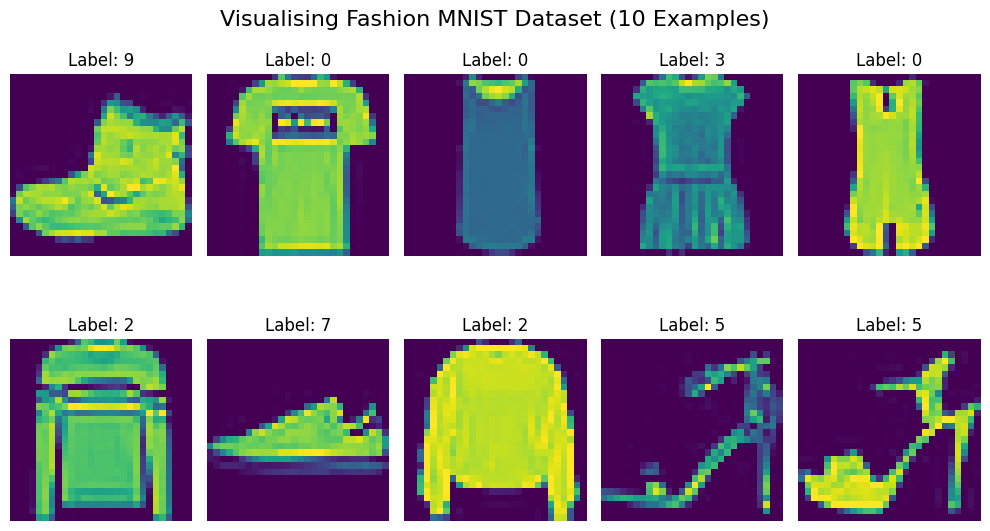

In [3]:
# Visualise the first 10 images in the training set
plt.figure(figsize = (10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(train_images[i])
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')  
plt.tight_layout()
plt.suptitle("Visualising Fashion MNIST Dataset (10 Examples)", fontsize = 16)
plt.show()

The labels are provided as integers, so we will need to map them to the corresponding clothing categories for the final predictions.

In [4]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#### Preprocess Data
Let's reshape the data and ensure pixel values in the images are normalised so the models can interpret them correctly. Whilst the labels don't necessarily need to be one-hot encoded, let's do so anyway for completeness. Finally, we'll need to split the entire dataset of 70,000 images into training, validation, and test sets using a 75/15/10 split, respectively.

In [5]:
# Combine the current train and test sets to create one dataset
images = np.concatenate([train_images, test_images], axis = 0)
labels = np.concatenate([train_labels, test_labels], axis = 0)

# Preprocess the data
num_classes = np.max(labels) + 1
images_mod = images.reshape((-1, images.shape[1], images.shape[1], 1)).astype('float32') / 255.0

In [6]:
# Split into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(images_mod, labels, test_size = 0.25)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.4)

In [7]:
# Print shape of datasets
print("Fashion MNIST Modified Dataset Dimensions")
print("Shape of training images:", x_train.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation images:", x_val.shape)
print("Shape of validation labels:", y_val.shape)
print("Shape of test images:", x_test.shape)
print("Shape of test labels:", y_test.shape)

Fashion MNIST Modified Dataset Dimensions
Shape of training images: (52500, 28, 28, 1)
Shape of training labels: (52500,)
Shape of validation images: (10500, 28, 28, 1)
Shape of validation labels: (10500,)
Shape of test images: (7000, 28, 28, 1)
Shape of test labels: (7000,)


#### Model Creation
We will be building various TensorFlow models and testing their performance on the test set to decide what the optimal configuration should be. During the training process, note that all models will incorporate:
- 10 epochs

- Batch size of 32

- ReLU activation function for hidden layers

- Softmax activation function for output layer

- Sparse Categorical Cross-Entropy loss

##### **Model 1: Simple Neural Network (Baseline)**

Build a simple neural network with 2 hidden layers and the Adam optimiser.

In [62]:
# Set up model by adding layers sequentially
base = models.Sequential()
base.add(layers.Flatten(input_shape = (x_train.shape[1], x_train.shape[1], 1)))
base.add(layers.Dense(units = 256, activation = 'relu'))
base.add(layers.Dense(units = 128, activation = 'relu'))

# Add output layer
base.add(layers.Dense(units = num_classes, activation = 'softmax'))

# Compile model
base.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# Define a History callback to record training metrics
base_history = History()

# Fit model on training data
base.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [base_history],  validation_data = (x_val, y_val))

# Print model summary
base.summary()

Epoch 1/10


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7814 - loss: 0.6136 - val_accuracy: 0.8553 - val_loss: 0.3997
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8645 - loss: 0.3722 - val_accuracy: 0.8767 - val_loss: 0.3466
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8742 - loss: 0.3358 - val_accuracy: 0.8776 - val_loss: 0.3390
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8864 - loss: 0.3034 - val_accuracy: 0.8769 - val_loss: 0.3322
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8932 - loss: 0.2818 - val_accuracy: 0.8846 - val_loss: 0.3213
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8996 - loss: 0.2677 - val_accuracy: 0.8879 - val_loss: 0.3115
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9033 - loss: 0.2523 - val_accuracy: 0.8812 - val_loss: 0.3319
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9050 - loss: 0.2447 - val_accurac

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705,440 (2.69 MB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 470,294 (1.79 MB)

Let's look at the training progress over all epochs.

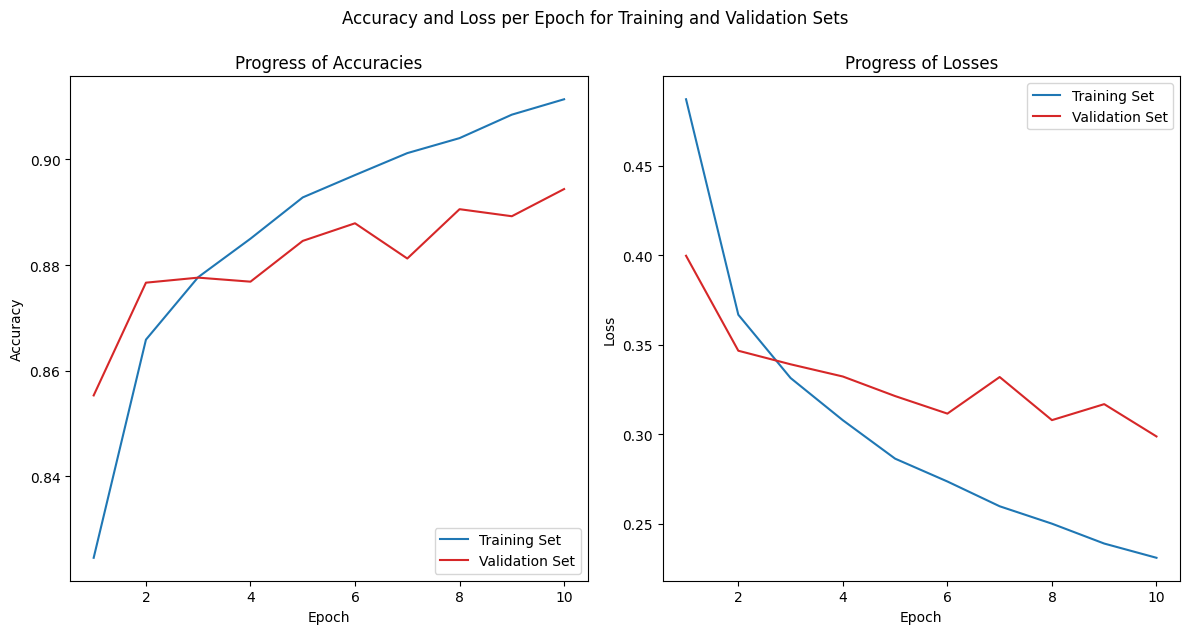

In [63]:
# Plot training progress for training and validation data
epochs = np.arange(1, 11)
training_progress(epochs, base_history.history['accuracy'], base_history.history['loss'], base_history.history['val_accuracy'], base_history.history['val_loss'])

**Comments**: Training accuracy increases and loss decreases steadily with the significant movements in the first 4 epochs, and gradually gets closer to convergence by the end of training. Validation accuracy and loss improve overall, but show fluctuations starting from the 6th epoch, suggesting potential overfitting to the training set. This is confirmed by the divergence of the two lines in each plot.

View performance metrics after predicting on the test set.

In [64]:
# Predict on test set
base_preds = base.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


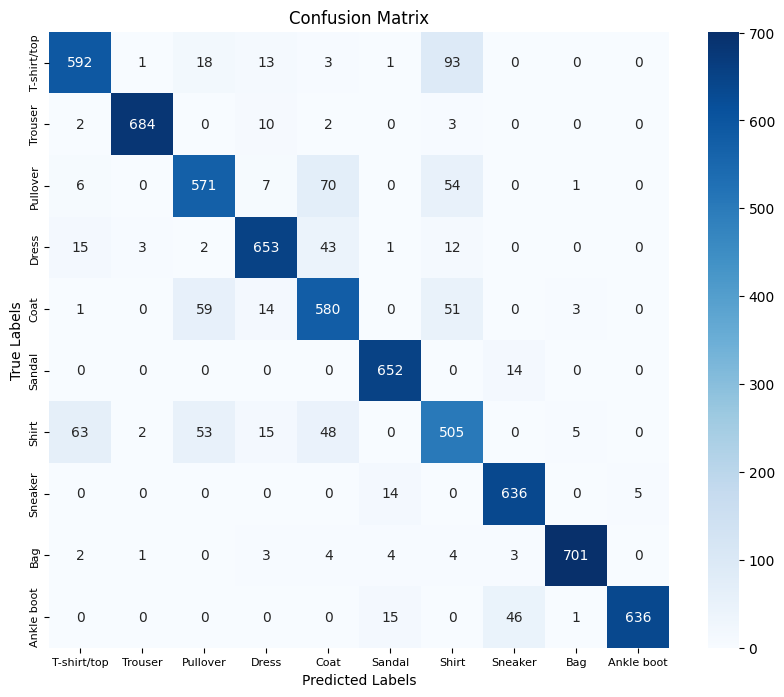

In [65]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

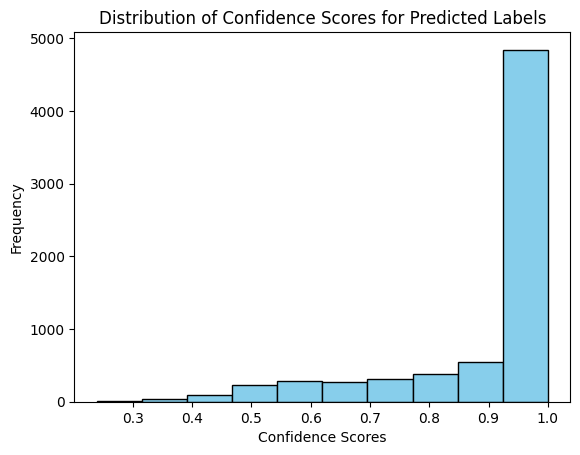

In [66]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [67]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.8693    0.8211    0.8445       721
           1     0.9899    0.9757    0.9828       701
           2     0.8122    0.8054    0.8088       709
           3     0.9133    0.8957    0.9044       729
           4     0.7733    0.8192    0.7956       708
           5     0.9491    0.9790    0.9638       666
           6     0.6994    0.7308    0.7148       691
           7     0.9099    0.9710    0.9394       655
           8     0.9859    0.9709    0.9784       722
           9     0.9922    0.9112    0.9500       698

    accuracy                         0.8871      7000
   macro avg     0.8895    0.8880    0.8882      7000
weighted avg     0.8894    0.8871    0.8878      7000



**Summary**: The model exhibited robust performance with an overall high accuracy and F1 macro score of around 89%, demonstrating strong capability across all classes. This was further supported by the confusion matrix, which showed prominent diagonal values, indicating robust predictions overall. Shirts were predicted least accurately often mistaken with upper body garments such as pullovers, coats, and t-shirts/tops, likely due to their similar shapes posing difficulties in differentiation. The model generally assigned high confidence scores to its predictions, with a majority exceeding 80%, underscoring its reliability in decision-making.

##### **Model 2: Deep Neural Network (DNN) - No Regularisation**

Build a deep neural network with 3 hidden layers and the Adam optimiser.

In [68]:
# Set up model by adding layers sequentially
dnn = models.Sequential()
dnn.add(layers.Flatten(input_shape = (x_train.shape[1], x_train.shape[1], 1)))

# Hidden layers with L2 regularization
dnn.add(layers.Dense(256, activation = 'relu'))
dnn.add(layers.Dense(128, activation = 'relu'))
dnn.add(layers.Dense(64, activation = 'relu'))

# Output layer
dnn.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile the model
dnn.compile(optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
dnn_history = History()

# Fit model on training data
dnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [dnn_history],  validation_data = (x_val, y_val))

# Print model summary
dnn.summary()

Epoch 1/10


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7774 - loss: 0.6316 - val_accuracy: 0.8300 - val_loss: 0.4841
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8601 - loss: 0.3888 - val_accuracy: 0.8686 - val_loss: 0.3577
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8725 - loss: 0.3408 - val_accuracy: 0.8691 - val_loss: 0.3573
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8853 - loss: 0.3117 - val_accuracy: 0.8783 - val_loss: 0.3332
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8873 - loss: 0.2984 - val_accuracy: 0.8781 - val_loss: 0.3360
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8951 - loss: 0.2768 - val_accuracy: 0.8735 - val_loss: 0.3353
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9004 - loss: 0.2632 - val_accuracy: 0.8903 - val_loss: 0.3054
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9057 - loss: 0.2526 - val_accurac

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,288 (2.78 MB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 485,526 (1.85 MB)

Let's look at the training progress over all epochs.

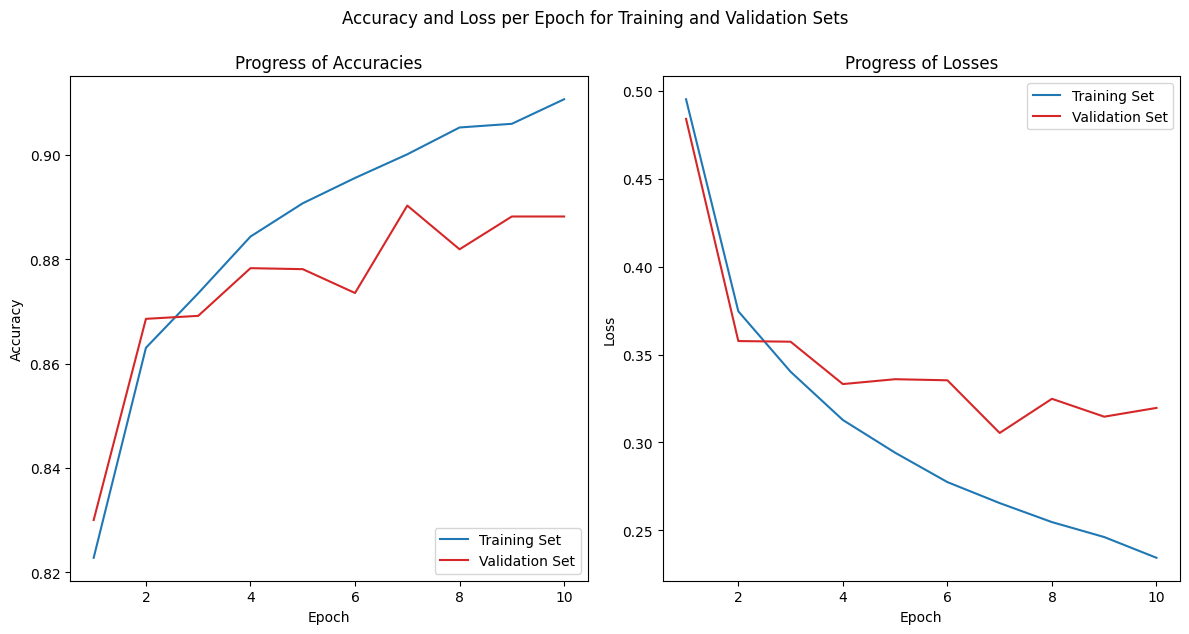

In [69]:
# Plot training progress for training and validation data
training_progress(epochs, dnn_history.history['accuracy'], dnn_history.history['loss'], dnn_history.history['val_accuracy'], dnn_history.history['val_loss'])

**Comments**: The training process showed consistent improvements, achieving a high training accuracy of 91% and a low loss of 0.23 by the final epoch. Similarly, validation accuracy and loss generally improved over time, though fluctuations emerged from the 5th epoch onward, suggesting potential overfitting to the training data with diverging trends in both accuracy and loss plots.

View performance metrics after predicting on the test set.

In [70]:
# Predict on test set
dnn_preds = dnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(dnn_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(dnn_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


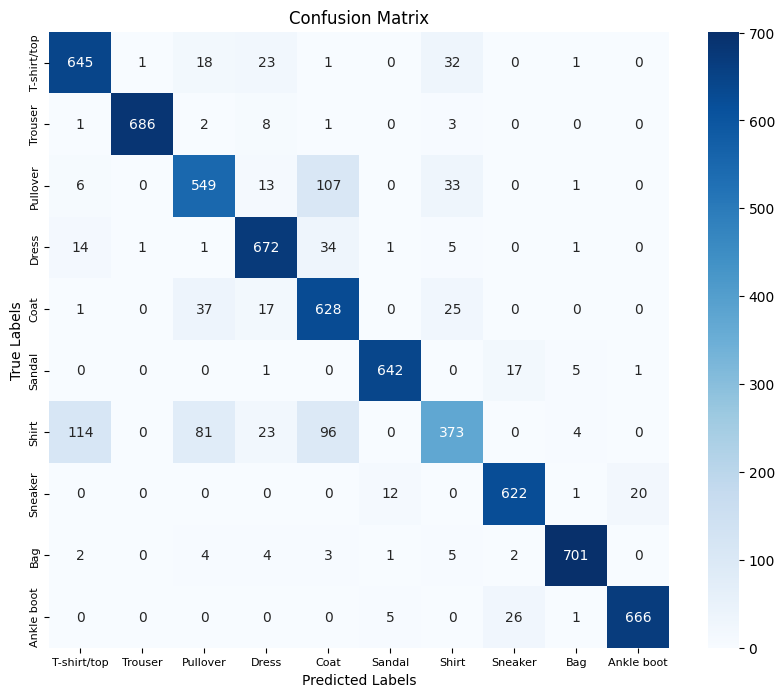

In [71]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

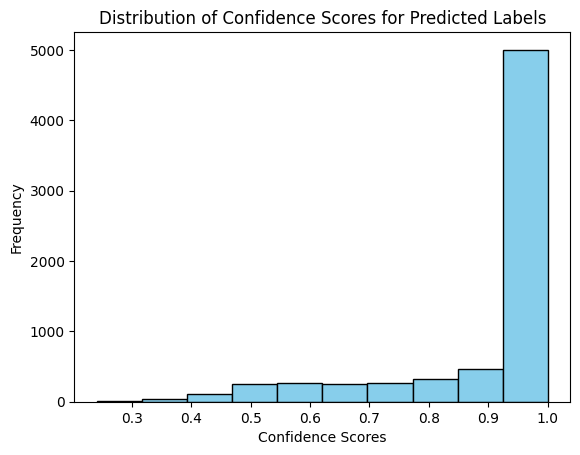

In [72]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [73]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.8238    0.8946    0.8577       721
           1     0.9971    0.9786    0.9878       701
           2     0.7934    0.7743    0.7837       709
           3     0.8830    0.9218    0.9020       729
           4     0.7218    0.8870    0.7959       708
           5     0.9713    0.9640    0.9676       666
           6     0.7836    0.5398    0.6392       691
           7     0.9325    0.9496    0.9410       655
           8     0.9804    0.9709    0.9756       722
           9     0.9694    0.9542    0.9617       698

    accuracy                         0.8834      7000
   macro avg     0.8856    0.8835    0.8812      7000
weighted avg     0.8848    0.8834    0.8808      7000



**Summary**: The model achieved an overall accuracy and F1 macro score of 88%, indicating effective prediction capabilities across all classes. Similar to Model 1, the confusion matrix reveals that shirts were often mistaken for other upper body garments such as t-shirts/tops, coats, and pullovers but comparatively had much worse predictions - potentially due to overfitting. Despite the high confidence scores (mostly over 80%), low precision for pullovers and shirts indicates that a significant portion of predictions for these classes were incorrect, while low recall for coats and shirts suggests that many actual instances of these classes were missed in predictions. The extra hidden layer compared to the baseline did not yield any significant gains.

##### **Model 3: Deep Neural Network (DNN) - With Regularisation**

Build a deep neural network with 3 hidden layers, the Adam optimiser, and L2-Regularisation for the first hidden layer.

In [117]:
# Set up model by adding layers sequentially
dnn_reg = models.Sequential()
dnn_reg.add(layers.Flatten(input_shape = (x_train.shape[1], x_train.shape[1], 1)))

# Hidden layers with L2 regularization
dnn_reg.add(layers.Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
dnn_reg.add(layers.Dense(128, activation = 'relu'))
dnn_reg.add(layers.Dense(64, activation = 'relu'))

# Output layer
dnn_reg.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile the model
dnn_reg.compile(optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
dnn_reg_history = History()

# Fit model on training data
dnn_reg.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [dnn_reg_history],  validation_data = (x_val, y_val))

# Print model summary
dnn_reg.summary()

Epoch 1/10


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7688 - loss: 0.9439 - val_accuracy: 0.8472 - val_loss: 0.4720
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8599 - loss: 0.4292 - val_accuracy: 0.8556 - val_loss: 0.4143
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8706 - loss: 0.3763 - val_accuracy: 0.8591 - val_loss: 0.4177
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8793 - loss: 0.3472 - val_accuracy: 0.8408 - val_loss: 0.4561
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8897 - loss: 0.3194 - val_accuracy: 0.8709 - val_loss: 0.3722
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8938 - loss: 0.3037 - val_accuracy: 0.8740 - val_loss: 0.3475
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8979 - loss: 0.2889 - val_accuracy: 0.8853 - val_loss: 0.3362
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9023 - loss: 0.2807 - val_accurac

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,288 (2.78 MB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 485,526 (1.85 MB)

Let's look at the training progress over all epochs.

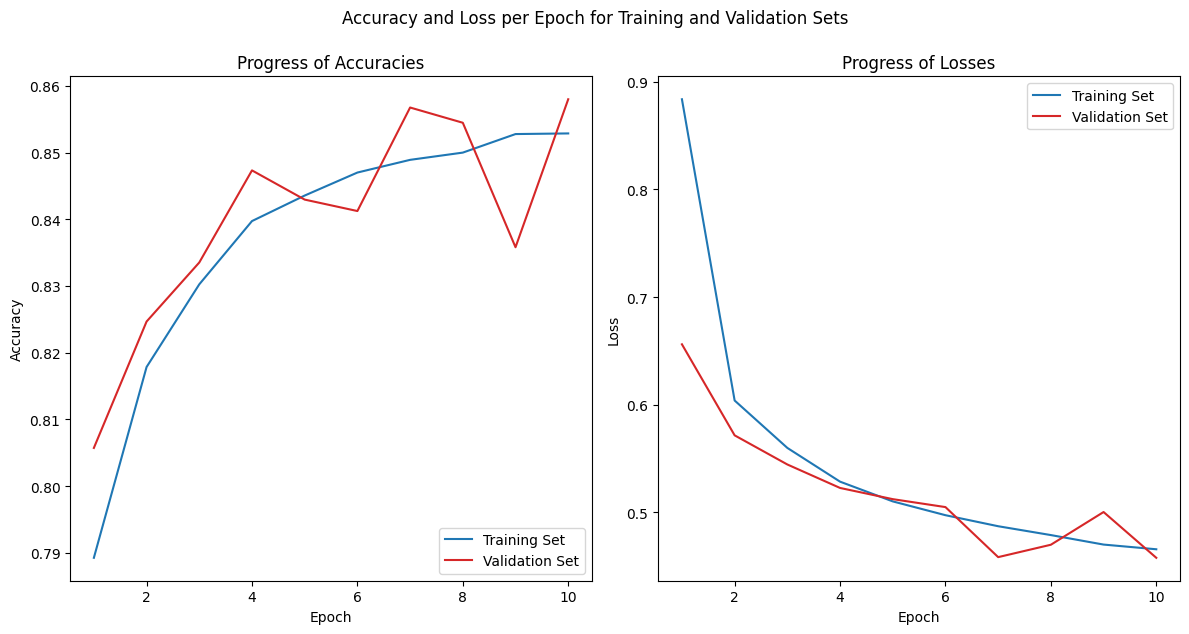

In [112]:
# Plot training progress for training and validation data
training_progress(epochs, dnn_reg_history.history['accuracy'], dnn_reg_history.history['loss'], dnn_reg_history.history['val_accuracy'], dnn_reg_history.history['val_loss'])

**Comments**: The training progress stabilised around epoch 8, and the model achieved a training accuracy of 91% and a loss of 0.25 at the last epoch. In contrast, validation progress exhibited fluctuations in accuracy and loss across all epochs. Overall, there was consistent improvement in validation metrics, and by epoch 10, accuracy and loss were better than those of the training set. Regularisation seemes to have mitigated overfitting by adding a penalty in the first hidden layer, although the model's performance is not superior to that of Model 2 (no regularisation).

View performance metrics after predicting on the test set.

In [108]:
# Predict on test set
dnn_reg_preds = dnn_reg.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(dnn_reg_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(dnn_reg_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


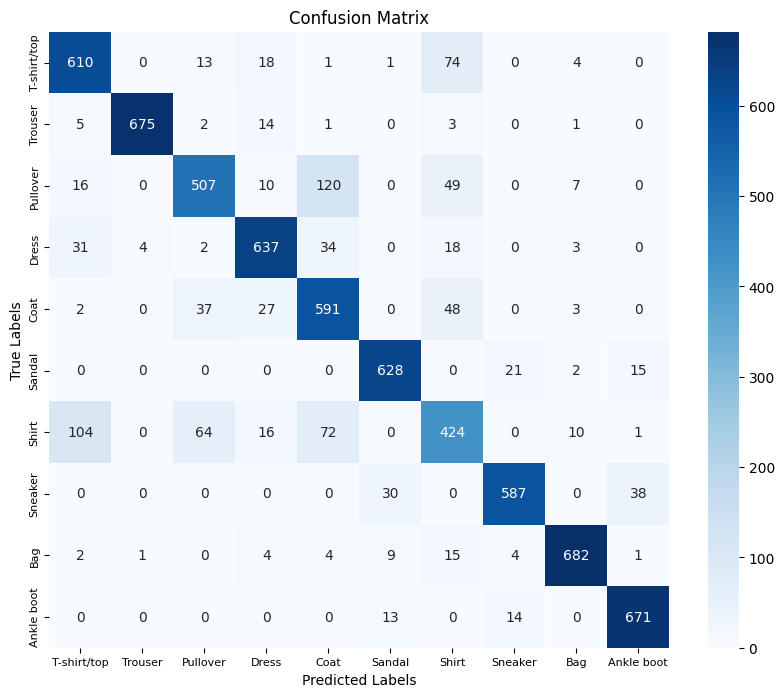

In [109]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

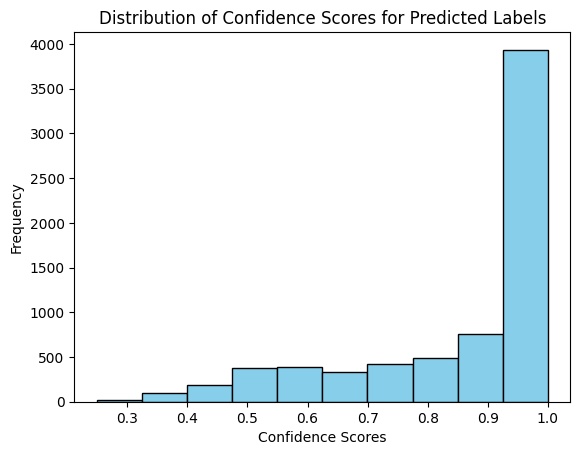

In [110]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [111]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.7922    0.8460    0.8182       721
           1     0.9926    0.9629    0.9776       701
           2     0.8112    0.7151    0.7601       709
           3     0.8774    0.8738    0.8756       729
           4     0.7181    0.8347    0.7720       708
           5     0.9222    0.9429    0.9324       666
           6     0.6719    0.6136    0.6415       691
           7     0.9377    0.8962    0.9165       655
           8     0.9579    0.9446    0.9512       722
           9     0.9242    0.9613    0.9424       698

    accuracy                         0.8589      7000
   macro avg     0.8605    0.8591    0.8588      7000
weighted avg     0.8599    0.8589    0.8583      7000



**Summary**: The model's confidence scores remained generally high but were more varied, ranging between 40% and 90% compared to previous models. The confusion matrix reveals consistent challenges with predicting shirts, albeit better than Model 2. Specifically, coats and shirts had lower precision values, indicating many incorrect predictions within those classes, while pullovers and shirts had lower recall values, suggesting missed instances during prediction. Despite regularisation, the model achieved an overall accuracy and F1 macro average of 86%, which is slightly worse than compared to Model 2 (no regularisation).

##### **Model 4: Convolutional Neural Network (CNN)**

Build a convolutional neural network with 3 convolutional layers, the SGD optimiser, and a dropout of 0.1 between the last 2 convolutional layers.

In [80]:
# Set up model by adding layers sequentially
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[1], 1)))
cnn.add(layers.MaxPooling2D((2, 2)))

# Add convolutional layers for localised feature extraction
cnn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.1))

cnn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(64, activation = 'relu'))
cnn.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile model
cnn.compile(optimizer = 'sgd',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
cnn_history = History()

# Fit model on training data
cnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [cnn_history],  validation_data = (x_val, y_val))

# Print model summary
cnn.summary()

Epoch 1/10


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.4187 - loss: 1.6457 - val_accuracy: 0.7429 - val_loss: 0.6703
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7584 - loss: 0.6491 - val_accuracy: 0.7934 - val_loss: 0.5491
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7931 - loss: 0.5549 - val_accuracy: 0.8141 - val_loss: 0.4960
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8156 - loss: 0.4931 - val_accuracy: 0.8273 - val_loss: 0.4584
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8286 - loss: 0.4662 - val_accuracy: 0.8389 - val_loss: 0.4440
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8381 - loss: 0.4393 - val_accuracy: 0.8490 - val_loss: 0.4029
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8450 - loss: 0.4159 - val_accuracy: 0.8553 - val_loss: 0.3888
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8510 - loss: 0.40

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,324 (364.55 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Let's look at the training progress over all epochs.

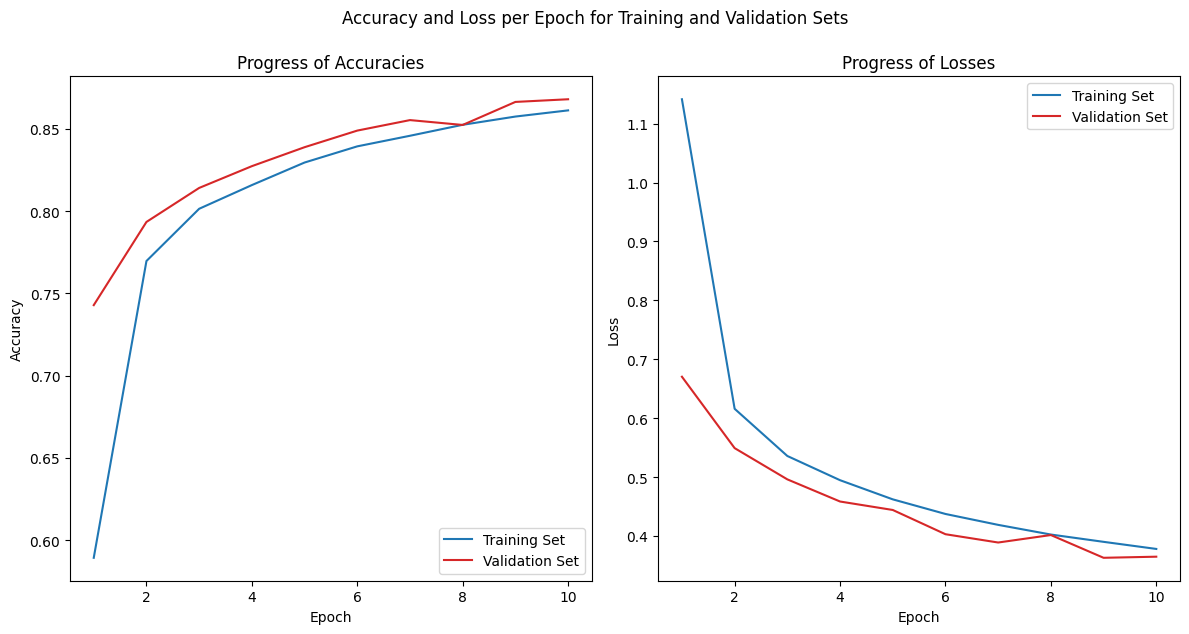

In [81]:
# Plot training progress for training and validation data
training_progress(epochs, cnn_history.history['accuracy'], cnn_history.history['loss'], cnn_history.history['val_accuracy'], cnn_history.history['val_loss'])

**Comments:** The training progress indicates closely aligned accuracy and loss between the training and validation sets throughout all epochs, both stabilizing at 86%. There are consistent improvements without any signs of overfitting observed, suggesting a well-generalised model across the datasets. 

View performance metrics after predicting on test set.

In [82]:
# Predict on test set
cnn_preds = cnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(cnn_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(cnn_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


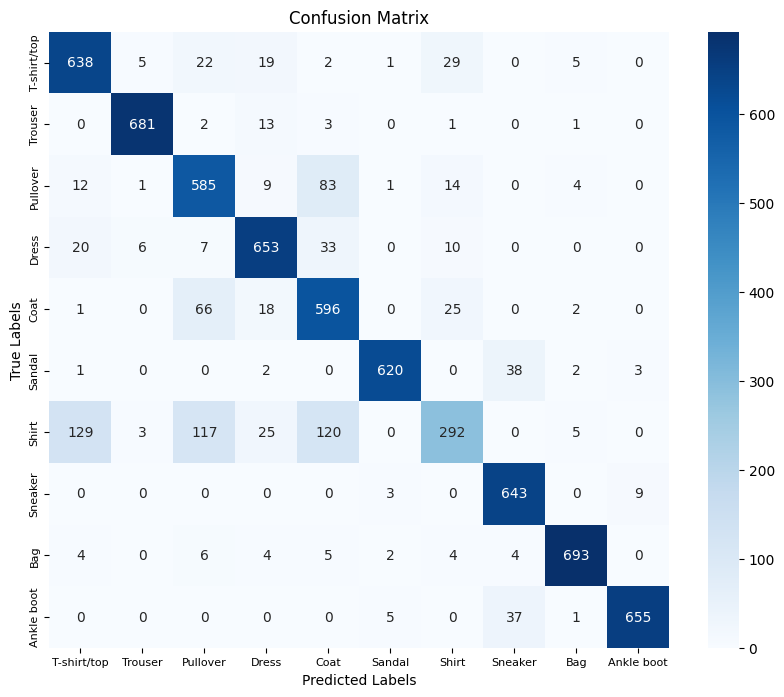

In [83]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

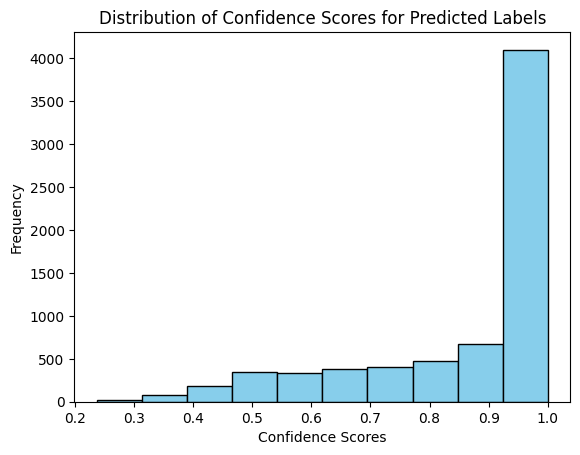

In [84]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [85]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.7925    0.8849    0.8362       721
           1     0.9784    0.9715    0.9749       701
           2     0.7267    0.8251    0.7728       709
           3     0.8789    0.8957    0.8872       729
           4     0.7078    0.8418    0.7690       708
           5     0.9810    0.9309    0.9553       666
           6     0.7787    0.4226    0.5478       691
           7     0.8906    0.9817    0.9339       655
           8     0.9719    0.9598    0.9659       722
           9     0.9820    0.9384    0.9597       698

    accuracy                         0.8651      7000
   macro avg     0.8689    0.8652    0.8603      7000
weighted avg     0.8680    0.8651    0.8599      7000



**Summary**: The confusion matrix indicated generally accurate predictions across most classes, except for shirts which performed notably worse, ranking as the weakest among all models evaluated thus far. Confidence scores remained relatively high with a significant proportion ranging between 50% and 80%. The model achieved an accuracy of 87% and an F1 macro score of 86%, making it somewhat comparable to the other models. Precision was notably low for pullovers and coats, with shirts showing extremely poor recall at 0.42 and an F1 score of 0.55, as highlighted by the confusion matrix. Given CNNs are usually quite good at capturing spatial dependencies and patterns, the above model architecture might need to be tweaked slightly to predict better on the test set.

##### **Model 5: Recurrent Neural Network (RNN)**

Build a recurrent neural network with 2 LSTM layers, the Adam optimiser, and L2-Regularisation in the first hidden layer.

In [86]:
# Set up model by adding layers sequentially
rnn = models.Sequential()
rnn.add(layers.Reshape((x_train.shape[1], x_train.shape[1]), input_shape = (x_train.shape[1], x_train.shape[1], 1)))

# LSTM layers with L2 regularization
rnn.add(layers.LSTM(256, return_sequences = True, kernel_regularizer = regularizers.l2(0.01)))
rnn.add(layers.LSTM(128, kernel_regularizer = regularizers.l2(0.01)))

# Output layer
rnn.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile the model
rnn.compile(optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
rnn_history = History()

# Fit model on training data
rnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [rnn_history],  validation_data = (x_val, y_val))

# Print model summary
rnn.summary()

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 116s 68ms/step - accuracy: 0.6838 - loss: 1.3381 - val_accuracy: 0.8143 - val_loss: 0.6023
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 113s 69ms/step - accuracy: 0.8048 - loss: 0.6116 - val_accuracy: 0.8159 - val_loss: 0.5629
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 106s 65ms/step - accuracy: 0.8267 - loss: 0.5402 - val_accuracy: 0.8210 - val_loss: 0.5518
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 108s 66ms/step - accuracy: 0.8374 - loss: 0.5044 - val_accuracy: 0.8331 - val_loss: 0.5275
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 109s 66ms/step - accuracy: 0.8488 - loss: 0.4694 - val_accuracy: 0.8515 - val_loss: 0.4426
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.8487 - loss: 0.4562 - val_accuracy: 0.8516 - val_loss: 0.4464
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 100s 61ms/step - accuracy: 0.8576 - loss: 0.4368 - val_accuracy: 0.8556 - val_loss: 0.4240
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 115s 70ms/step - accuracy: 

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28, 256)        │       291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,470,752 (5.61 MB)

 Trainable params: 490,250 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 980,502 (3.74 MB)

Let's look at the training progress over all epochs.    

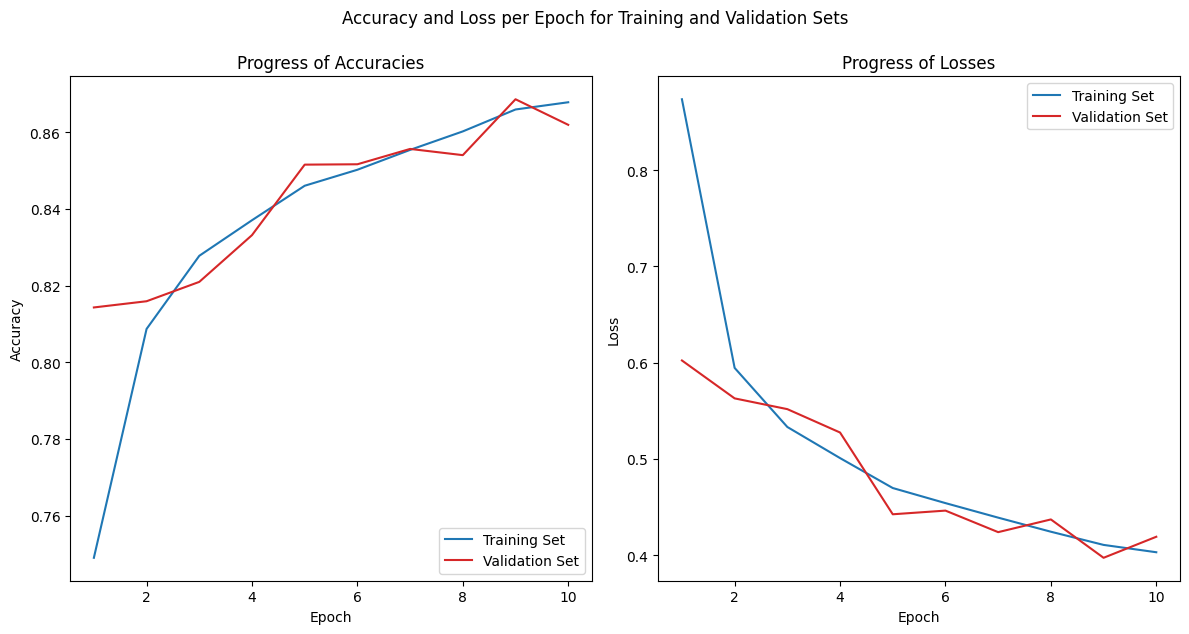

In [87]:
# Plot training progress for training and validation data
training_progress(epochs, rnn_history.history['accuracy'], rnn_history.history['loss'], rnn_history.history['val_accuracy'], rnn_history.history['val_loss'])

**Comments:** Accuracy and loss showed consistent improvement across epochs for both training and validation sets, with occasional fluctuations in validation progress whilst loosely mirroring the training set. Peak accuracy reached approximately 87% with a loss close to 0.40 for both training and validation. There were no indications of significant overfitting throughout the training process, possibly due to L2-Regularisation.

View performance metrics after predicting on the test set.

In [88]:
# Predict on test set
rnn_preds = rnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(rnn_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(rnn_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step


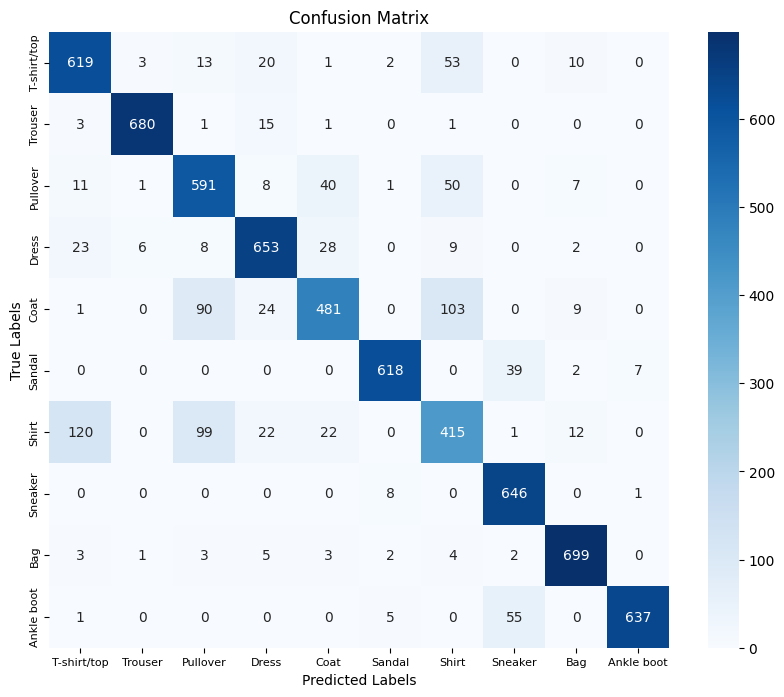

In [89]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

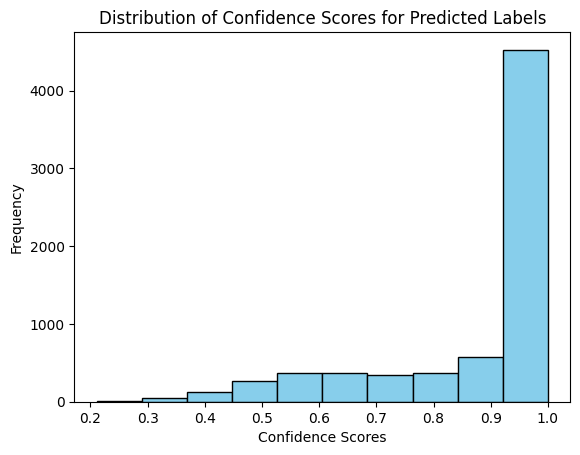

In [90]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [91]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.7926    0.8585    0.8242       721
           1     0.9841    0.9700    0.9770       701
           2     0.7342    0.8336    0.7807       709
           3     0.8742    0.8957    0.8848       729
           4     0.8351    0.6794    0.7492       708
           5     0.9717    0.9279    0.9493       666
           6     0.6535    0.6006    0.6259       691
           7     0.8694    0.9863    0.9242       655
           8     0.9433    0.9681    0.9556       722
           9     0.9876    0.9126    0.9486       698

    accuracy                         0.8627      7000
   macro avg     0.8646    0.8633    0.8620      7000
weighted avg     0.8641    0.8627    0.8615      7000



**Summary**: The model made generally good predictions across all classes, though shirts were frequently confused with t-shirts/tops and pullovers, and coats with pullovers and shirts. Confidence scores were predominantly high, with a minor distribution around 60% to 80%. The accuracy and F1 score of 86% closely matched previous models. However, the shirt class exhibited low precision, recall, and F1 score. RNNs are typically used to process sequential data as they are good at retaining information from past inputs. As a result, it is not surprising that the model did not perform better than the baseline (Model 1) despite the training process taking over 17 minutes.

##### **Model 6: Residual Network (ResNet)**

Build a residual neural network with 1 convolutional layer, 1 residual block, the Adam optimiser, and a dropout layer.

In [18]:
# Define Residual Block
def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters, kernel_size, padding = 'same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2D(filters, kernel_size, padding = 'same')(y)
    y = layers.BatchNormalization()(y)
    
    # Skip connection
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size = (1, 1), padding = 'same')(x)
    y = layers.add([x, y])
    y = layers.Activation('relu')(y)
    return y

# Define ResNet model
def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape = input_shape)
    
    # Initial convolutional layer
    x = layers.Conv2D(64, (3, 3), padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3))(x)
    
    x = layers.Dropout(0.1)(x)
    # Residual blocks
    x = residual_block(x, filters = 64, kernel_size = (3, 3))
    
    x = layers.Dropout(0.1)(x)  
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Create ResNet model
input_shape = x_train.shape[1:]
resnet = ResNet(input_shape, num_classes)

# Compile the model
resnet.compile(optimizer = 'adam',
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

# Define a History callback to record training metrics
resnet_history = History()

# Fit model on training data
resnet.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [resnet_history],  validation_data = (x_val, y_val))

# Print model summary
resnet.summary()

Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.7260 - loss: 0.8094 - val_accuracy: 0.6714 - val_loss: 0.8188
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 63s 38ms/step - accuracy: 0.8469 - loss: 0.4297 - val_accuracy: 0.8016 - val_loss: 0.5359
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - accuracy: 0.8715 - loss: 0.3607 - val_accuracy: 0.8285 - val_loss: 0.4911
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.8787 - loss: 0.3346 - val_accuracy: 0.8662 - val_loss: 0.3713
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - accuracy: 0.8881 - loss: 0.3139 - val_accuracy: 0.8315 - val_loss: 0.4633
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.8924 - loss: 0.2963 - val_accuracy: 0.8470 - val_loss: 0.4478
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.8955 - loss: 0.2886 - val_accuracy: 0.8801 - val_loss: 0.3490
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 61s 37ms/step - accuracy: 0.9001 -

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 9, 9, 64)  │          0 │ activation_18[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 9, 9, 64)  │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 9, 9, 64)  │          0 │ dropout_7[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 9, 9, 64)  │          0 │ add_6[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 9, 9, 64)  │          0 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dropout_8[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        650 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,976 (886.63 KB)

 Trainable params: 75,530 (295.04 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 151,062 (590.09 KB)

Let's look at the training progress over all epochs.    

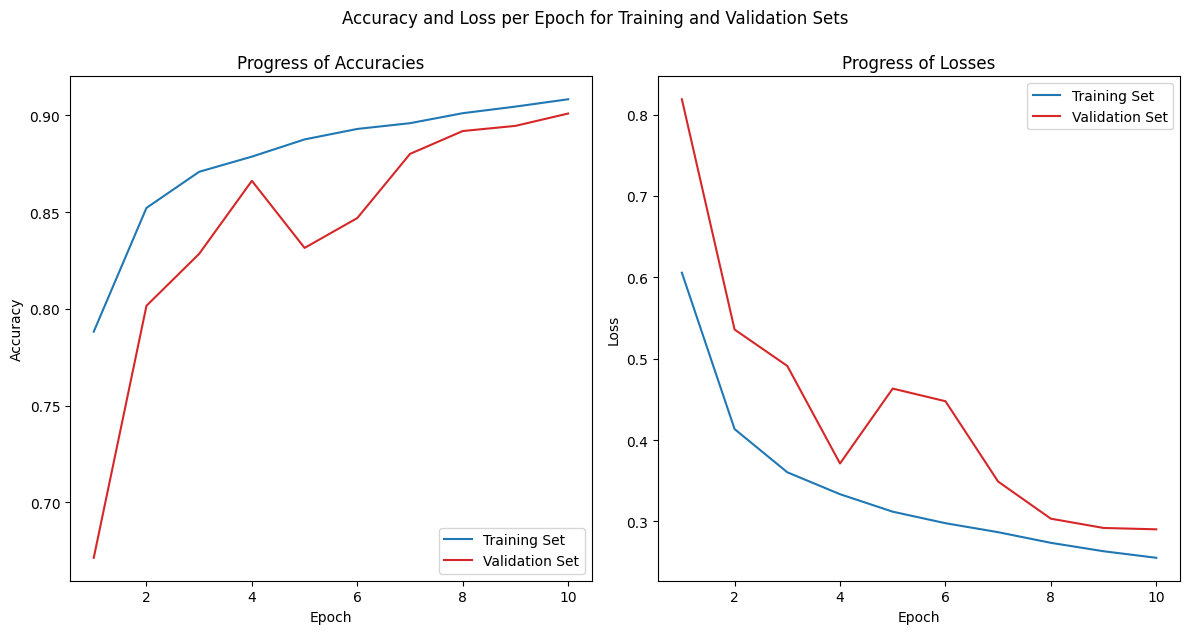

In [19]:
# Plot training progress for training and validation data
training_progress(epochs, resnet_history.history['accuracy'], resnet_history.history['loss'], resnet_history.history['val_accuracy'], resnet_history.history['val_loss'])

**Comments:**

View performance metrics after predicting on the test set.

In [30]:
# Define Residual Block
def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters, kernel_size, padding = 'same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2D(filters, kernel_size, padding = 'same')(y)
    y = layers.BatchNormalization()(y)
    
    # Skip connection
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size = (1, 1), padding = 'same')(x)
    y = layers.add([x, y])
    y = layers.Activation('relu')(y)
    return y

# Define ResNet model
def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape = input_shape)
    
    # Initial convolutional layer
    x = layers.Conv2D(64, (3, 3), padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3))(x)
    
    # Residual blocks
    x = residual_block(x, filters = 64, kernel_size = (3, 3))
    
    x = layers.Dropout(0.25)(x)  
    x = residual_block(x, filters = 64, kernel_size = (3, 3))
    x = layers.Dropout(0.25)(x)  
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Create ResNet model
input_shape = x_train.shape[1:]
resnet = ResNet(input_shape, num_classes)

# Compile the model
resnet.compile(optimizer = 'adam',
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

# Define a History callback to record training metrics
resnet_history = History()

# Fit model on training data
resnet.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [resnet_history],  validation_data = (x_val, y_val))

# Print model summary
resnet.summary()

Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.7569 - loss: 0.6984 - val_accuracy: 0.8678 - val_loss: 0.3620
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.8707 - loss: 0.3541 - val_accuracy: 0.8773 - val_loss: 0.3410
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 88s 53ms/step - accuracy: 0.8925 - loss: 0.2957 - val_accuracy: 0.8563 - val_loss: 0.4151
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 89s 54ms/step - accuracy: 0.9035 - loss: 0.2704 - val_accuracy: 0.9074 - val_loss: 0.2532
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 91s 55ms/step - accuracy: 0.9096 - loss: 0.2484 - val_accuracy: 0.8953 - val_loss: 0.2942
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 84s 51ms/step - accuracy: 0.9146 - loss: 0.2322 - val_accuracy: 0.8703 - val_loss: 0.3674
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 95s 58ms/step - accuracy: 0.9216 - loss: 0.2139 - val_accuracy: 0.8439 - val_loss: 0.4149
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 95s 58ms/step - accuracy: 0.9251 -

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 9, 9, 64)  │          0 │ activation_30[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ max_pooling2d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 9, 9, 64)  │          0 │ max_pooling2d_10… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 9, 9, 64)  │          0 │ add_10[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 9, 9, 64)  │          0 │ activation_32[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 9, 9, 64)  │     36,928 │ activation_33[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 449,568 (1.71 MB)

 Trainable params: 149,642 (584.54 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 299,286 (1.14 MB)

In [31]:
# Predict on test set
resnet_preds = resnet.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(resnet_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(resnet_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


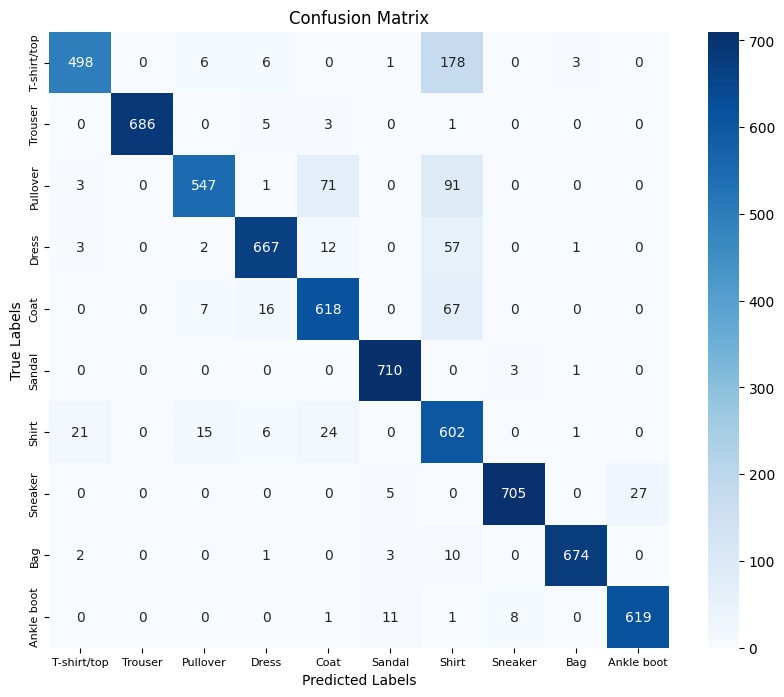

In [32]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

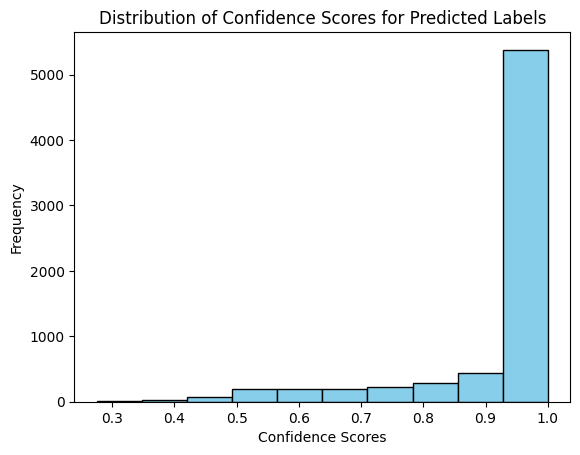

In [33]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [34]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.9450    0.7197    0.8171       692
           1     1.0000    0.9871    0.9935       695
           2     0.9480    0.7672    0.8481       713
           3     0.9501    0.8989    0.9238       742
           4     0.8477    0.8729    0.8601       708
           5     0.9726    0.9944    0.9834       714
           6     0.5978    0.8999    0.7184       669
           7     0.9846    0.9566    0.9704       737
           8     0.9912    0.9768    0.9839       690
           9     0.9582    0.9672    0.9627       640

    accuracy                         0.9037      7000
   macro avg     0.9195    0.9041    0.9061      7000
weighted avg     0.9210    0.9037    0.9068      7000



**Summary**: 

#### Results

all models achieved similar results on test set, with resnet (model 6), closely followed by dnn (model 2) and the baselines (model 1). 
baseline and dnn did not take long to train at all, howvere, could be argued that they overfit on training data so not best for looking at generalised use case
resnet managed to prevent overfitting and achieve good results on all classes, and addressed the problem of tackling upper body garment distinguishing 
residual blocks good at gradient vanishing problem and its not hard to see why the 2015 paper became so important for the future of deep learning and pre-trained models/transfer learning

#### Ambiguous Images
Using the best model, find the 10 most ambiguous images in the test set based on predicted confidence scores.

In [98]:
# Get the lowest confidence scores from predictions above for ResNet (Model 6)